# Import packages

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


%matplotlib inline
plt.style.use('bmh')

# Read data

In [3]:
# Data from Kaggle competition
comp_data_df_train = pd.read_csv("data/competition-data/train.csv")
df_test = pd.read_csv("data/competition-data/test.csv")

# Original data
orig_data_df = pd.read_csv("data/original-data/smoking.csv")

In [4]:
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [5]:
orig_data_df.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


In [6]:
comp_data_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [7]:
orig_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

# Combine datasets

In [8]:
# drop columns
comp_data_df_train = comp_data_df_train.drop(columns=['id'])
orig_data_df = orig_data_df.drop(columns=['ID', 'gender', 'oral', 'tartar'])

In [9]:
orig_data_df.shape

(55692, 23)

In [10]:
print("competition train shape:", comp_data_df_train.shape)
print("original train shape:", orig_data_df.shape)

competition train shape: (159256, 23)
original train shape: (55692, 23)


In [11]:
# combine datasets
df_train = pd.concat([comp_data_df_train, orig_data_df])
df_train.shape

(214948, 23)

# Clean data

## Remove duplicate rows

In [12]:
df_train = df_train.drop_duplicates()
df_train.shape

(203808, 23)

## Check for missing values

We can see that there are no missing values in the train or test dataset

In [13]:
df_train.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [14]:
df_test.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

## Rename columns

In [15]:
new_col_names = {
    "systolic": "systolic bp",
    "relaxation": "diastolic bp",
    "Gtp": "GGT",
    "dental caries": "dental cavities"
}

df_train = df_train.rename(columns=new_col_names)
df_test = df_test.rename(columns=new_col_names)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203808 entries, 0 to 44552
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  203808 non-null  int64  
 1   height(cm)           203808 non-null  int64  
 2   weight(kg)           203808 non-null  int64  
 3   waist(cm)            203808 non-null  float64
 4   eyesight(left)       203808 non-null  float64
 5   eyesight(right)      203808 non-null  float64
 6   hearing(left)        203808 non-null  float64
 7   hearing(right)       203808 non-null  float64
 8   systolic bp          203808 non-null  float64
 9   diastolic bp         203808 non-null  float64
 10  fasting blood sugar  203808 non-null  float64
 11  Cholesterol          203808 non-null  float64
 12  triglyceride         203808 non-null  float64
 13  HDL                  203808 non-null  float64
 14  LDL                  203808 non-null  float64
 15  hemoglobin           20

## Change blindness value to 0

This dataset uses the Korean vision scoring system which goes from 0.1 to 2.0. In this dataset an eyesight value of 9.9 indicates blindness. In order to keep ordinality we will change this so 0 indicates blindness

In [16]:
df_train['eyesight(left)'] = df_train['eyesight(left)'].replace(to_replace=9.9, value=0)
df_train['eyesight(right)'] = df_train['eyesight(right)'].replace(to_replace=9.9, value=0)

df_test['eyesight(left)'] = df_test['eyesight(left)'].replace(to_replace=9.9, value=0)
df_test['eyesight(right)'] = df_test['eyesight(right)'].replace(to_replace=9.9, value=0)

# EDA

In [17]:
df_train.describe(include='all').transpose()  # using transpose to see all columns easier

,count,mean,std,min,25%,50%,75%,max
age,203808.0,44.285656,11.896734,20.0,40.0,40.0,55.0,85.0
height(cm),203808.0,165.133606,8.906900,130.0,160.0,165.0,170.0,190.0
weight(kg),203808.0,66.868185,12.649219,30.0,55.0,65.0,75.0,135.0
waist(cm),203808.0,82.799830,9.037021,51.0,76.8,83.0,89.0,129.0
eyesight(left),203808.0,0.997088,0.315326,0.0,0.8,1.0,1.2,2.0
eyesight(right),203808.0,0.993224,0.314272,0.0,0.8,1.0,1.2,2.0
hearing(left),203808.0,1.024332,0.154077,1.0,1.0,1.0,1.0,2.0
hearing(right),203808.0,1.023993,0.153028,1.0,1.0,1.0,1.0,2.0
systolic bp,203808.0,122.290631,12.951378,71.0,113.0,121.0,130.0,240.0
diastolic bp,203808.0,76.692470,9.158813,40.0,70.0,77.0,82.0,146.0


## Distribution of Target Variable

The target variable, smoking, is relatively balanced. 

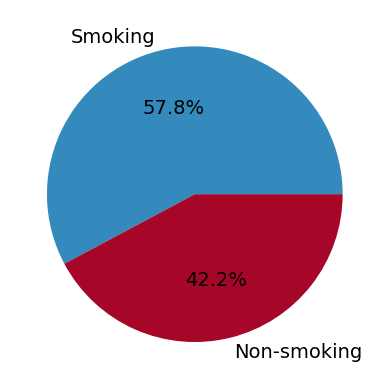

In [18]:
plt.pie(df_train['smoking'].value_counts(), labels=['Smoking', 'Non-smoking'], autopct='%1.1f%%', textprops={'fontsize': 14});

## Distribution of features

We can see below that some features have skewed distrubutions and others have been bucketed. Features such as hemoglobin and waist have clear differences in their smoking distributions. 

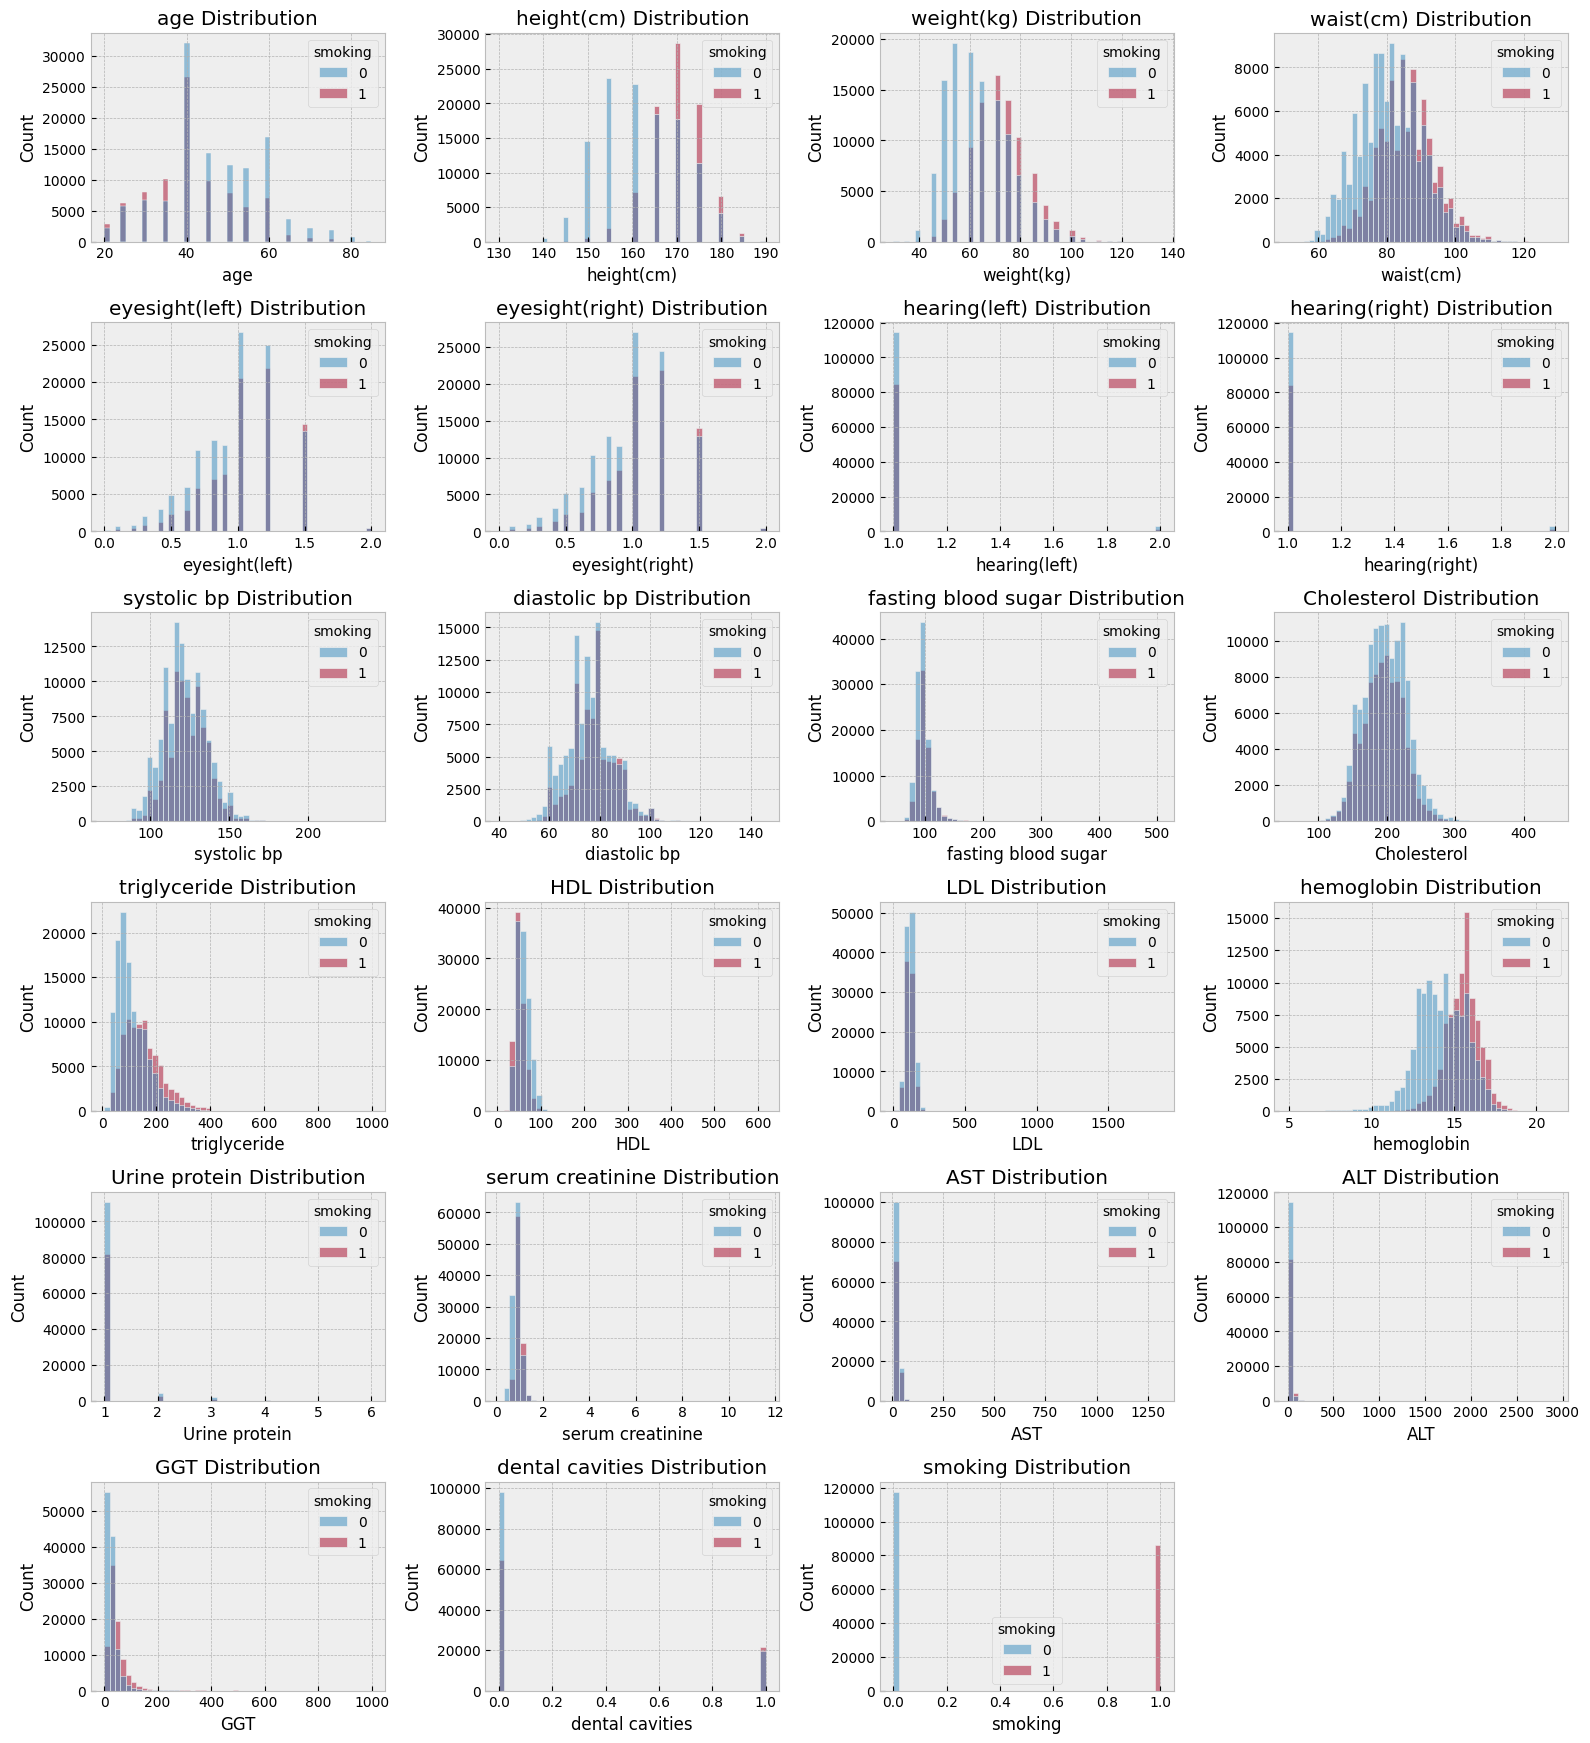

In [19]:
num_cols = len(df_train.columns)
plt.figure(figsize=(16, num_cols*1.5))
for i, col in enumerate(df_train.columns):
    plt.subplot(num_cols//2 + num_cols%2, 4, i + 1)
    sns.histplot(x=col, hue='smoking', data=df_train, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

## Feature Importance

### Smoking Rate
**Smoking rate**: Difference between mean of the target variable and mean of categories for a feature. If this difference is greater than 0, it means that the category is less likely to be smoking, and if the difference is lower than 0, the group is more likely to be smoking. The larger differences are indicators that a variable is more important than others.

In [20]:
global_smoking = df_train.smoking.mean()
global_smoking

0.4219903046004082

In [21]:
df_train[df_train['dental cavities'] == 0].smoking.mean()

0.3959069321651727

In [22]:
df_train[df_train['dental cavities'] == 1].smoking.mean()

0.5254233158728225

In [25]:
categorical_cols = [
    'age',
    'height(cm)',
    'weight(kg)',
    'hearing(left)',
    'hearing(right)',
    'dental cavities'
]
for c in categorical_cols:
    print(c)
    df_group = df_train.groupby(c).smoking.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_smoking
    df_group['risk'] = df_group['mean'] / global_smoking
    display(df_group)
    print()
    print()

age


,mean,count,diff,risk
age,,,,
20,0.554276,5122,0.132285,1.313480
25,0.516985,11952,0.094994,1.225110
30,0.541914,14685,0.119923,1.284185
35,0.603320,16686,0.181330,1.429701
40,0.452238,58770,0.030247,1.071678
45,0.403870,24134,-0.018120,0.957060
49,0.000000,1,-0.421990,0.000000
50,0.388809,20195,-0.033181,0.921370
55,0.321184,17504,-0.100807,0.761116




height(cm)


,mean,count,diff,risk
height(cm),,,,
130,0.000000,1,-0.421990,0.000000
135,0.153846,13,-0.268144,0.364573
139,0.000000,1,-0.421990,0.000000
140,0.017301,578,-0.404689,0.040999
145,0.030678,3716,-0.391312,0.072699
150,0.034216,15139,-0.387774,0.081083
155,0.077142,25680,-0.344849,0.182805
160,0.238947,29923,-0.183044,0.566237
165,0.516309,38078,0.094318,1.223508




weight(kg)


,mean,count,diff,risk
weight(kg),,,,
30,0.105263,19,-0.316727,0.249444
35,0.064103,78,-0.357888,0.151905
40,0.068146,1262,-0.353845,0.161487
45,0.070060,7308,-0.351930,0.166023
50,0.122994,18196,-0.298996,0.291462
55,0.200667,24583,-0.221323,0.475525
60,0.333594,28145,-0.088396,0.790525
65,0.464336,29666,0.042346,1.100348
70,0.540247,30375,0.118257,1.280235




hearing(left)


,mean,count,diff,risk
hearing(left),,,,
1.0,0.424734,198849,0.002744,1.006503
2.0,0.311958,4959,-0.110032,0.739254




hearing(right)


,mean,count,diff,risk
hearing(right),,,,
1.0,0.424547,198918,0.002556,1.006058
2.0,0.317996,4890,-0.103994,0.753562




dental cavities


,mean,count,diff,risk
dental cavities,,,,
0,0.395907,162763,-0.026083,0.938190
1,0.525423,41045,0.103433,1.245108


### Correlation Matrix

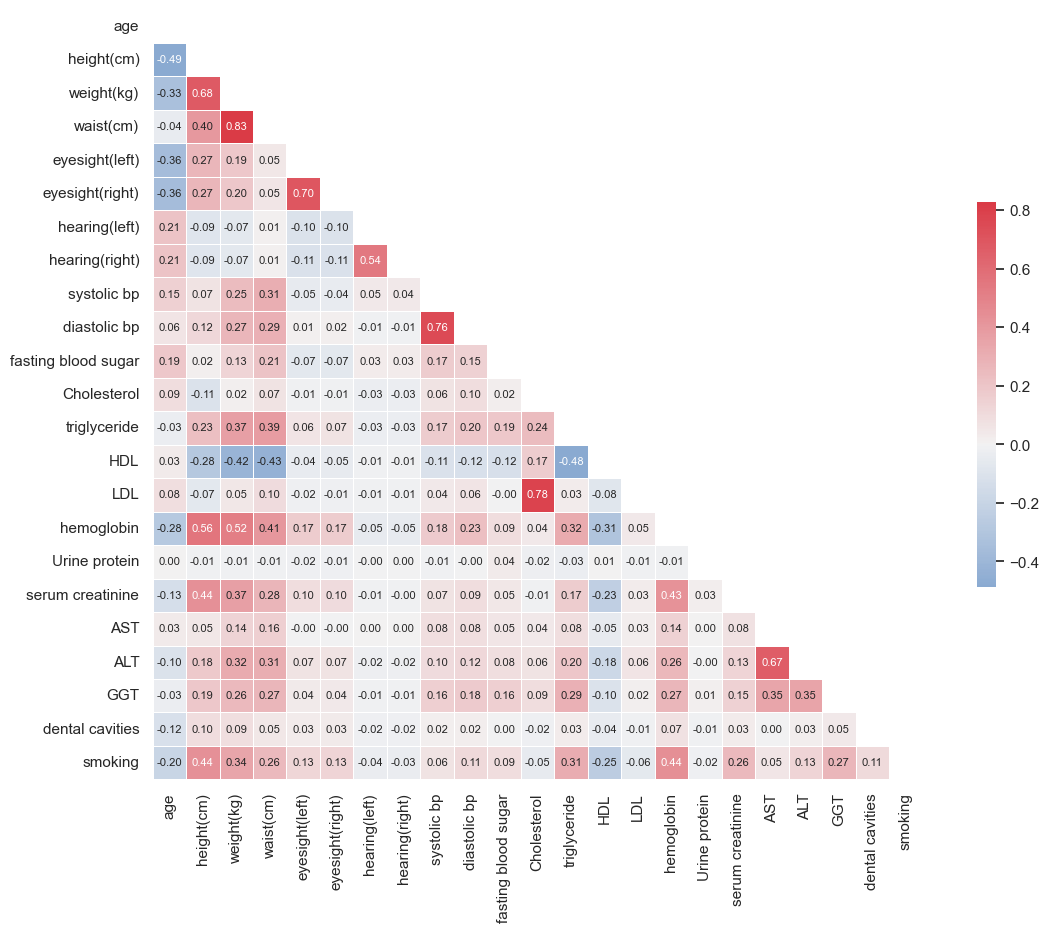

In [59]:
sns.set_theme(style="white")

corr_mat = df_train.corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
fig, ax = plt.subplots(figsize=(14, 10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            fmt='.2f', annot=True, annot_kws={'size': 8});